## Stochastic Gradient Descent

We calculate the loss and gradient based on only **one sample**.   (Not recommended due to unstability)

$$\frac{\partial J}{\partial \theta_j} = (h^{(i)}-y^{(i)})x_j$$

## Mini-Batch Gradient Descent

We calculate the loss and gradient based on **subset of samples**.  (Recommended; used as standard in deep learning)

$$\frac{\partial J}{\partial \theta_j} = \sum_{i=start}^{batch}(h^{(i)}-y^{(i)})x_j$$

## Polynomial Regression

Limitation of simple linear regression comes when we have non-linear data.  We can simply use polynomial regression, which applies feature engineering using polynomial transformation.  For example, a degree-1 polynomial fits a straight line to the data like this: 

$$y = ax + b$$  

A degree-3 polynomial fits a cubic curve to the data 

$$y = ax^3 + bx^2 + cx + d$$

For example,

In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

x = np.array([[1, 2, 3]])
poly_X = PolynomialFeatures(degree = 2, include_bias=False).fit_transform(x)

print(poly_X)
#here 1, 2, 3 is of power 1; and 1, 2, 3, 4, 6, 9 is power 2 

[[1. 2. 3. 1. 2. 3. 4. 6. 9.]]


## Code

Before anything, do this on the terminal

        docker compose up

This will build the mlflow service for you, which you can access via http://localhost:5000

**MLFlow** is a popular experiment tracking tool.  Everyone love it and use it.  Here I just demonstrated a very simple usage - please continue to self-study.

In [2]:
#experiment tracking
import mlflow
import os
# This the dockerized method.
# We build two docker containers, one for python/jupyter and another for mlflow.
# The url `mlflow` is resolved into another container within the same composer.
mlflow.set_tracking_uri("http://localhost:5000")
# In the dockerized way, the user who runs this code will be `root`.
# The MLflow will also log the run user_id as `root`.
# To change that, we need to set this environ["LOGNAME"] to your name.
os.environ["LOGNAME"] = "chaky"
# mlflow.create_experiment(name="chaky-diabetes-example")  #create if you haven't create
mlflow.set_experiment(experiment_name="chaky-diabetes-example")

<Experiment: artifact_location='mlflow-artifacts:/571139252409316201', creation_time=1690250901046, experiment_id='571139252409316201', last_update_time=1690250901046, lifecycle_stage='active', name='chaky-diabetes-example', tags={}>

In [3]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from time import time

diabetes = load_diabetes()
print("Features: ", diabetes.feature_names)
X = diabetes.data
y = diabetes.target
m = X.shape[0]  #number of samples
n = X.shape[1]  #number of features

#polynomial transformation
X   = PolynomialFeatures(degree = 3, include_bias=False).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# actually you can do like this too
# X = np.insert(X, 0, 1, axis=1)
intercept = np.ones((X_train.shape[0], 1))
X_train   = np.concatenate((intercept, X_train), axis=1)
intercept = np.ones((X_test.shape[0], 1))
X_test    = np.concatenate((intercept, X_test), axis=1)

Features:  ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


Here, I want to demonstrate some techniques:
- **Class** - it's much better to write any in the class form, as you can modularize it for future use, so please be comfortable with it
- **Early stopping** - it's expensive to run the model until a certain set of iterations; instead, we can stop when the training loss is no longer decreasing
- **Cross validation** - we never really do cross validation from scratch, so here I showed you how to do it

Some terms worth mentioning:
- **Epoch** - it's a popular term in ML/DL - one epoch refers to a training and validation process with all the training data with one model.

Some coding practice worth mentioning:
- Notice how I put `_` in front of some function; it does not really have any functionality aside from telling the coders that it is not meant for outside use (should not be called from `__main__`)

In [4]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

class LinearRegression(object):
    
    #in this class, we add cross validation as well for some spicy code....
    kfold = KFold(n_splits=5)
            
    def __init__(self, alpha=0.001, num_epochs=50, batch_size=50, method='batch', cv=kfold):
        self.alpha      = alpha
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.cv         = cv

    def mse(self, ytrue, ypred):
        return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]
    
    def fit(self, X_train, y_train):
            
        #create a list of kfold scores
        self.kfold_scores = list()
        
        #reset val loss
        self.val_loss_old = np.infty

        #kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
            
            self.theta = np.zeros(X_cross_train.shape[1])
            
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            
            #one epoch will exhaust the WHOLE training set
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                
                params = {"method": self.method, "alpha": self.alpha}
                mlflow.log_params(params=params)
                
                for epoch in range(self.num_epochs):
                
                    #with replacement or no replacement
                    #with replacement means just randomize
                    #with no replacement means 0:50, 51:100, 101:150, ......300:323
                    #shuffle your index
                    perm = np.random.permutation(X_cross_train.shape[0])
                            
                    X_cross_train = X_cross_train[perm]
                    y_cross_train = y_cross_train[perm]
                    
                    if self.method == 'sto':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                            y_method_train = y_cross_train[batch_idx]                    
                            train_loss = self._train(X_method_train, y_method_train)
                    elif self.method == 'mini':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            #batch_idx = 0, 50, 100, 150
                            X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                            y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                            train_loss = self._train(X_method_train, y_method_train)
                    else:
                        X_method_train = X_cross_train
                        y_method_train = y_cross_train
                        train_loss = self._train(X_method_train, y_method_train)

                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)
                    
                    #record dataset
                    mlflow_train_data = mlflow.data.from_numpy(features=X_method_train, targets=y_method_train)
                    mlflow.log_input(mlflow_train_data, context="training")
                    
                    mlflow_val_data = mlflow.data.from_numpy(features=X_cross_val, targets=y_cross_val)
                    mlflow.log_input(mlflow_val_data, context="validation")
                    
                    #early stopping
                    if np.allclose(val_loss_new, self.val_loss_old):
                        break
                    self.val_loss_old = val_loss_new
            
                self.kfold_scores.append(val_loss_new)
                print(f"Fold {fold}: {val_loss_new}")
            
                    
    def _train(self, X, y):
        yhat = self.predict(X)
        grad = X.T @(yhat - y)
        self.theta = self.theta - self.alpha * grad
        return self.mse(y, yhat)
    
    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.theta[0]

## Experiment

### Batch

In [5]:
params = {"method": "batch", "alpha": 0.0001}
mlflow.start_run(run_name=f"method-{params['method']}-alpha-{params['alpha']}", nested=True)

# #######

lr = LinearRegression(**params) #<==try put method="batch" or "sto"
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
mse  = lr.mse(yhat, y_test)

# print the mse
print("Test MSE: ", mse)
mlflow.log_metric(key="test_mse", value=mse)

signature = mlflow.models.infer_signature(X_train, lr.predict(X_train))
mlflow.sklearn.log_model(lr, artifact_path='model', signature=signature)

# #######

mlflow.end_run()


Fold 0: 13732.136636566456
Fold 1: 26921.996285052184
Fold 2: 16876.085474673368
Fold 3: 7002.471766979607
Fold 4: 11516.428498748342
Test MSE:  7303.484488284969


/Users/chaklam/Github/Machine-Learning/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Mini-batch

In [6]:
params = {"method": "mini", "alpha": 0.0001}
mlflow.start_run(run_name=f"method-{params['method']}-alpha-{params['alpha']}", nested=True)

#######

lr = LinearRegression(**params)
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
mse  = lr.mse(yhat, y_test)

# print the mse
print("Test MSE: ", mse)
mlflow.log_metric(key="test_mse", value=mse)

signature = mlflow.models.infer_signature(X_train, lr.predict(X_train))
mlflow.sklearn.log_model(lr, artifact_path='model', signature=signature)

#######

mlflow.end_run()


Fold 0: 13546.376131711779
Fold 1: 26645.97285413863
Fold 2: 16897.1180598921
Fold 3: 6952.267964438058
Fold 4: 11538.66920624072
Test MSE:  7334.658787211293


## Some graphs...

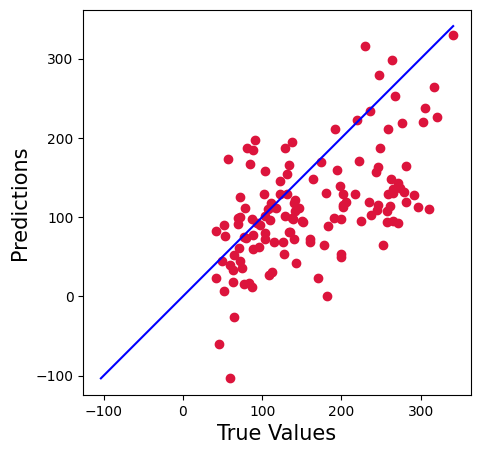

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_test, yhat, c='crimson')

p1 = max(max(yhat), max(y_test))
p2 = min(min(yhat), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Group Workshop - Check your understandings

Answer the following questions:

Instruction:  Gather in your group.  Will randomly pick groups to present.

1.  Explain why Chaky teach stochastic and mini-batch gradient descent.  Why we should care?  Explain in your own words.
2.  What's the shape of `X_train` and `y_train`?
3.  What does `batch_size=50` means?
4.  what is `np.infty`?  Why is set like that?
5.  What is `enumerate(self.cv.split(X_train))`
6.  What's the shape of `X_cross_train` and `y_cross_train`?
7.  What's the shape of `X_method_train` and `y_method_train` in the case of stochastic gradient descent?
8.  What's the shape of `X_method_train` and `y_method_train` in the case of mini-batch gradient descent?
9.  What's the shape of `X_method_train` and `y_method_train` in the case of batch gradient descent?
10. In https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection, there are many ways to split and `KFold` is the simplest.  Try do `enumerate` the `ShuffleSplit` and tells us what index it gave us.   If you are confused, see the examples shown in https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
11. Change our code so that it uses `ShuffleSplit`.  Report the Test MSE.
12. Please learn about `TimeSeriesSplit` by yourself, as it is used in time series data.
13. In one `epoch`, we train a model using all training data.  Which line(s) of code makes sure we used all the training data?
14. What is `np.random.permutation` and what does it give you?  Demonstrate your answer with trial code.
15. In a line `X_method_train = X_cross_train[batch_idx].reshape(1, -1)`, why do we need to reshape?
16. In a line `yhat_val = self.predict(X_cross_val)`, when should validation happens?  
17. What does this line do: `if np.allclose(val_loss_new, self.val_loss_old): break`?
18. Explain why the coefficients can be achieved via `return self.theta[1:]`
19. Perform an experiment comparing these parameters using cross-validation: `alpha: {0.1, 0.01, 0.001}`, `method:{'batch', 'sto', 'mini'}`, `poly: {True, False}`.  Write a short  report discussing the phenemonons.